### 6.1 Working with text data

文本是最常见的序列数据之一，一般理解为单词序列。由于深度学习模型并非接收原始文本作为输入，它只能处理数值张量。因此要先将文本向量化vectorize，一般有以下几种实现方法：

- 将文本分割为单词，并将每个单词转换为一个向量
- 将文本分割为字符，并将每个字符转换为一个向量
- 提取单词或字符的n-gram，并将每个n-gram转换为一个向量。n-gram是多个相邻单词或字符的集合，n-gram之间可以重叠。

将文本分解而成的单元(单词、字符或n-gram)叫作token，将文本分解为标记的过程叫作分词(tokenization)。所有文本向量化过程都是**应用某种分词方案，然后将数值向量与生成的标记相关联。**本接介绍两种方法，one-hot encoding与token embedding。

n-gram的词袋模型是一种特征工程工具，不适用于深度学习模型，但对于轻量级的浅层文本处理模型(如logistic回归和random forest)是重要且不可或缺的。

#### 6.1.1 One-hot encoding of words and characters

one-hot编码是将token转换为向量最基本的方法。它将每个单词和一个唯一的整数index相关联，并将这个整数index转换为长度为N的二进制向量(N是词表大小)。

下面是单词级的one-hot编码和字符级的one-hot编码的简单示例：

In [1]:
import numpy as np

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

token_index = {}
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1

max_length = 10

results = np.zeros(shape=(len(samples),
                          max_length,
                          max(token_index.values())+ 1))

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1

Keras中提供了内置函数，其可以对原始文本数据进行单词级或字符级的one-hot编码。这些函数一般实现了许多重要特性，应该使用它们对文本数据进行编码处理。

In [3]:
# 6-3 Using Keras for word-level one-hot encoding
from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(samples)

# to list
sequences = tokenizer.texts_to_sequences(samples)

# to one-hot tensor
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9 unique tokens.


one-hot encoding的一种变体是one-hot hashing trick，适用于词表中token数目太大而无法直接处理的情况。这种方法没有为每个单词显示分配一个index，而是将单词hash encode为固定长度的向量，这一步通常用一个简单的hash function实现。优点在于避免维护一个显式的单词索引，从而能够节省内存并允许数据的online encoding(在读取完所有数据前即可生成encoding)；缺点在于可能出现hash collision。

#### 6.1.2 Using word embeddings

word embedding相比于one-hot编码的词向量，具有以下特征：
- one-hot词向量稀疏、高维、hard-code
- word embedding密集、低维且从数据中学习得到

word embedding的获取有两种方法：
- 在完成主任务的同时学习该任务上的embedding。
- 在不同于待解决问题的机器学习任务上预先计算好word embedding，然后将其加载到模型中，这种word embedding叫作pretrained word embedding。

##### Learning word embedding with Embedding layer

词向量之间的几何关系应该表示这些词之间的语义关系。也即word embedding的作用应该是将人类的语言映射到几何空间中。词与词之间的distance和direction应该都是meaningful的。

对于一特定任务如需学习一个其word embeddings对应的嵌入空间，意味着要学习一个层的weights，这个层也即是Embedding层。

In [8]:
from keras.layers import Embedding

embedding_layer = Embedding(1000, 64)

Embedding层至少需要两个参数，input_dim可理解为token个数，output_dim可理解为embedding的维度。这样一来，Embedding层就可以被视为一个字典，它将单词的整数索引映射为密集向量，实际上就是一种字典查找。

这个Embedding层的input应该是一个shape为(samples, sequence_length)的张量，其中sequence_length用zero padding等方法做到长度一致。而output的shape应该是(samples, sequence_length, embedding_dimensionality)，之后可以用RNN层或者1D conv层来处理这个三维张量。

下面在IMDB的电影评论数据集上训练一个word embedding，将评论长度限制为只有20个单词，词表选择前10000个单词。

In [11]:
from keras.datasets import imdb
from keras import preprocessing

max_features = 10000
maxlen = 20

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=
                                                     max_features)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [12]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))

model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10, batch_size=32,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 36s 2ms/step - loss: 0.6759 - acc: 0.6050 - val_loss: 0.6398 - val_acc: 0.6814
Epoch 2/10
20000/20000 [==============================] - 8s 415us/step - loss: 0.5657 - acc: 0.7427 - val_loss: 0.5467 - val_acc: 0.7206
Epoch 3/10
20000/20000 [==============================] - 9s 432us/step - loss

可以看到最后训练出的Embedding层的表示用于二分类任务的分类精度约为75%。但是用Dense层而非序列模型的RNN unit作分类会导致模型对输入序列中的每个单词单独处理，而并没有考虑单词之间的关系和句子结构。

##### Using pretrained word embedding

当手头可用的训练数据很少时，可从pretrained的embedding空间加载word embedding。通常这个pretrained embedding space是高度结构化的，且抓住了语言结构的一般特点。这样可以不必在解决问题的同时学习word embedding。

有许多pretrained的word embedding，都可以下载并在Keras的Embedding层中使用，如word2vec和GloVe。

#### 6.1.3 Putting it all together: from raw text to word embeddings

本节中将使用GloVe作为embedding实现IMDB数据集上的情感分类，其中IMDB的数据将使用IMDB的原始文本数据，而不是Keras内置的已经预先分词的IMDB数据。

In [3]:
import os

imdb_dir = r'C:\Users\10750\Desktop\notebook\datasets\aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname),'r',encoding='UTF-8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100 # maximum 100 words per comment in IMDB
# validation of GloVe, so only train on 200 samples
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('%s unique tokens in full set.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# shuffle process
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

88582 unique tokens in full set.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [5]:
glove_dir = r'C:\Users\10750\Desktop\notebook\datasets\glove.6B'

embedding_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), 'r', encoding='UTF-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embedding_index))

Found 400000 word vectors.


In [6]:
# prepare the embedding matrix to load into Embedding Layer
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [7]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
# ? why Embedding out_dim shape=(None, 100, 100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [9]:
# load GloVe Embedding
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False # freeze the pretrained layer

In [11]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 4s 20ms/step - loss: 1.4617 - acc: 0.4600 - val_loss: 0.6944 - val_acc: 0.5282
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.6007 - acc: 0.6400 - val_loss: 0.9004 - val_acc: 0.4956
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4924 - acc: 0.7650 - val_loss: 0.6964 - val_acc: 0.5448
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4251 - acc: 0.8650 - val_loss: 0.7815 - val_acc: 0.5181
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3012 - acc: 0.8900 - val_loss: 0.7326 - val_acc: 0.5333
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3427 - acc: 0.8600 - val_loss: 1.0132 - val_acc: 0.4960
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 0.1702 - acc: 0.9600 - val_loss: 0.8879 - val_acc: 0.5260
Epoch 8/10
200/200 [=======

### 6.2 Understanding recurrent neural networks

在此之前，我们见到的所有neural networks都有一个共同特点：它们没有记忆。对于一段文本这样的序列化输入，network将整个序列转换为单个输入张量并feed到feedforward network中，但这显然和人类理解text的方法是不同的。

人阅读一个句子的时候，一般是一个单词一个单词阅读，在一次阅读中会同时记住之前的内容，从而动态理解这个句子的含义。

RNN，即循环神经网络采用相同的原理，在model内保存一个state，包含与已知内容相关的信息，并在单个的序列上遍历输入。下面用Numpy来实现一个简单RNN的forward：RNN的输入是一个shape为(timesteps, input_features)的2D tensor，在每个timestep，model考虑t时刻的当前状态和t时刻的当前输入，对二者进行计算得到t时刻的输出，然后将下一个timestep的状态设置为上一个timestep的输出。用伪代码表示如下:

state_t = 0 # initial state
for input_t in input_sequence:
    # output_t = f(input_t, state_t)
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t

In [12]:
import numpy as np

timesteps = 100
input_features = 32
output_features = 64

inputs = np.random.random(size=(timesteps, input_features))

# initial state: zero initialization
state_t = np.zeros((output_features, ))

# random weights matrix
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = [] # sequential output
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    
    successive_outputs.append(output_t)
    
    state_t = output_t
    
final_output_sequence = np.stack(successive_outputs, axis=0)

以上cell中的代码是Numpy中RNN的简单实现，其使用一个for循环，重复使用循环中前一次迭代的计算结果。RNN的特征在于其timestep函数。

many-to-one的task下，通常只需要最后一个timestep的输出，因为其已经包含了整个序列的信息。

#### 6.2.1 A recurrent layer in Keras

上面Numpy的简单实现，对应了Keras层中的SimpleRNN层：
from keras.layers import SimpleRNN
尽管两者有一些区别：SimpleRNN可以处理批量数据，即(batch_size, timesteps, input_features)shape的输入。

同样的，考虑到RNN可能对应many-to-many或many-to-one的任务，SimpleRNN也可以在两种模式下运行:返回(batch_size, timesteps, input_features)的完整输出序列或只返回(batch_size, input_features)的最终输出，由return_sequences参数控制。

In [14]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


有时候为了提高网络的表示能力，将多个RNN层逐个堆叠起来也是很有用的。在这种情况下中间层必须返回完整的输出序列：

In [15]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


下面，我们将RNN model应用于IMDB情感分类问题：

In [17]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
maxlen = 500
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

input_train = sequence.pad_sequences(input_train,maxlen=maxlen)
input_test = sequence.pad_sequences(input_test,maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
input_train shape: (25000, 500)
input_test shape: (25000, 500)


In [18]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10, batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 55s 3ms/step - loss: 0.6428 - acc: 0.6140 - val_loss: 0.5919 - val_acc: 0.6680
Epoch 2/10
20000/20000 [==============================] - 55s 3ms/step - loss: 0.4190 - acc: 0.8197 - val_loss: 0.4217 - val_acc: 0.8208
Epoch 3/10
20000/20000 [==============================] - 48s 2ms/step - loss: 0.2999 - acc: 0.8804 - val_loss: 0.3777 - val_acc: 0.8306
Epoch 4/10
20000/20000 [==============================] - 51s 3ms/step - loss: 0.2484 - acc: 0.9024 - val_loss: 0.3601 - val_acc: 0.8530
Epoch 5/10
20000/20000 [==============================] - 54s 3ms/step - loss: 0.2203 - acc: 0.9127 - val_loss: 0.3728 - val_acc: 0.8730
Epoch 6/10
20000/20000 [==============================] - 47s 2ms/step - loss: 0.1512 - acc: 0.9455 - val_loss: 0.3916 - val_acc: 0.8708
Epoch 7/10
20000/20000 [==============================] - 49s 2ms/step - loss: 0.1037 - acc: 0.9633 - val_loss: 0.5807 - val_acc:

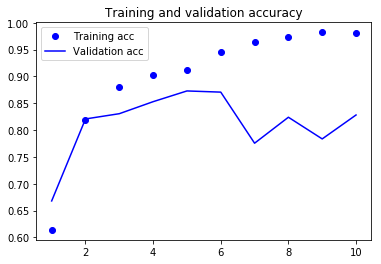

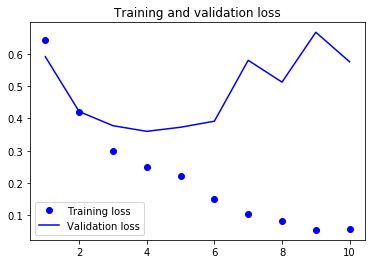

In [19]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

从上面的acc图可以看出，这个RNN的表现甚至不如第一个simple method的baseline。原因包括了：输入只考虑了前500个单词而非整个序列；SimpleRNN并不擅长处理长序列，比如文本。

#### 6.2.2 Understanding LSTM and GRU layers
